# Portfolio Piece: Word Embeddings to Attention 

**What I’m doing here:**
- I load pre-trained word embeddings.
- I explore: nearest neighbors + a couple analogies.
- I do a small bias-style probe (cosine similarity + a tiny WEAT-like score).
- I implement scaled dot-product attention in PyTorch and plot attention weights.
- I connect the two: use embeddings for a sentence and run self-attention to see “who attends to who”.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from typing import List, Tuple, Optional

## 1) Load embeddings 

I try `gensim.downloader` to load a small pre-trained model like GloVe 50d.


In [2]:
def normalize(v: np.ndarray) -> np.ndarray:
    v = np.asarray(v, dtype=np.float32)
    return v / (np.linalg.norm(v) + 1e-12)

def cosine(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(normalize(a), normalize(b)))

def try_load_gensim_model(name: str = "glove-wiki-gigaword-50"):
    try:
        import gensim.downloader as api
        return api.load(name)
    except Exception as e:
        print("Could not load gensim embeddings (this is ok). Reason:", repr(e))
        return None
    
def get_vector(word: str) -> Optional[np.ndarray]:
    w = word.lower()
    return np.array(model[w], dtype=np.float32) if w in model else None

def has_word(word: str) -> bool:
    return get_vector(word) is not None

model = try_load_gensim_model("glove-wiki-gigaword-50")
print("Using gensim model?", model is not None)



Using gensim model? True


## 2) Embedding exploration

Nearest neighbors tell you what’s close in the embedding space.
Analogies show the classic vector arithmetic idea.


In [3]:
def nearest_neighbors(word: str, topn: int = 10) -> List[Tuple[str, float]]:
    if not has_word(word):
        return []
    if model is not None:
        return [(w, float(s)) for w, s in model.most_similar(word, topn=topn)]

    v = get_vector(word)
    scores = []
    for w, vec in toy.items():
        if w == word:
            continue
        scores.append((w, cosine(v, vec)))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:topn]

for w in ["king", "paris", "doctor", "bank"]:
    if has_word(w):
        print(f"\nNeighbors for '{w}':")
        for nn, s in nearest_neighbors(w, topn=8):
            print(f"  {nn:>12s}  {s:.3f}")



Neighbors for 'king':
        prince  0.824
         queen  0.784
            ii  0.775
       emperor  0.774
           son  0.767
         uncle  0.763
       kingdom  0.754
        throne  0.754

Neighbors for 'paris':
    prohertrib  0.861
        france  0.803
      brussels  0.780
     amsterdam  0.777
        french  0.774
        vienna  0.739
        london  0.729
        berlin  0.726

Neighbors for 'doctor':
         nurse  0.798
     physician  0.797
       patient  0.761
         child  0.756
       teacher  0.754
       surgeon  0.748
  psychiatrist  0.742
       doctors  0.739

Neighbors for 'bank':
         banks  0.870
    securities  0.800
       banking  0.797
    investment  0.785
      exchange  0.781
     financial  0.767
        credit  0.765
        lender  0.752


In [4]:
def analogy(a: str, b: str, c: str, topn: int = 5):
    # a : b :: c : ?  ->  v(b) - v(a) + v(c)
    va, vb, vc = get_vector(a), get_vector(b), get_vector(c)
    if any(v is None for v in [va, vb, vc]):
        return None

    target = normalize(vb - va + vc)

    vocab = model.key_to_index.keys() if model is not None else toy.keys()
    scores = []
    for w in vocab:
        if w in [a, b, c]:
            continue
        vw = get_vector(w)
        if vw is None:
            continue
        scores.append((w, cosine(target, vw)))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:topn]

tests = [("man", "king", "woman"), ("france", "paris", "england")]
for a, b, c in tests:
    if has_word(a) and has_word(b) and has_word(c):
        print(f"\nAnalogy: {a} : {b} :: {c} : ?")
        print(analogy(a, b, c, topn=5))



Analogy: man : king :: woman : ?
[('queen', 0.8609581589698792), ('daughter', 0.7684512138366699), ('prince', 0.7640699744224548), ('throne', 0.7634971141815186), ('princess', 0.7512728571891785)]

Analogy: france : paris :: england : ?
[('melbourne', 0.8352906703948975), ('london', 0.819377064704895), ('edinburgh', 0.7828958034515381), ('glasgow', 0.7820128798484802), ('dublin', 0.7723953723907471)]


## 3) Bias-style probe 

Here we
- Compare similarity of professions to male vs female words
- Compute a tiny WEAT-like score (difference of average similarities)


In [5]:
def avg_cosine(words_a, words_b) -> float:
    vals = []
    for wa in words_a:
        for wb in words_b:
            va, vb = get_vector(wa), get_vector(wb)
            if va is None or vb is None:
                continue
            vals.append(cosine(va, vb))
    return float(np.mean(vals)) if vals else float("nan")

male = ["he", "man"]
female = ["she", "woman"]
professions = ["doctor", "nurse", "programmer", "teacher"]

rows = []
for p in professions:
    if not has_word(p):
        continue
    rows.append({
        "profession": p,
        "sim_to_male": avg_cosine([p], male),
        "sim_to_female": avg_cosine([p], female),
        "male_minus_female": avg_cosine([p], male) - avg_cosine([p], female),
    })

bias_df = pd.DataFrame(rows).sort_values("male_minus_female", ascending=False)
bias_df


,profession,sim_to_male,sim_to_female,male_minus_female
2,programmer,0.259283,0.224244,0.035039
0,doctor,0.701592,0.726727,-0.025135
3,teacher,0.651947,0.688927,-0.036980
1,nurse,0.526190,0.680599,-0.154410


In [6]:
def weat_like_score(X, Y, A, B) -> float:
    # s(w, A, B) = mean_cos(w, A) - mean_cos(w, B)
    def s(w):
        return avg_cosine([w], A) - avg_cosine([w], B)

    X = [w for w in X if has_word(w)]
    Y = [w for w in Y if has_word(w)]
    if len(X) == 0 or len(Y) == 0:
        return float("nan")

    return float(np.mean([s(x) for x in X]) - np.mean([s(y) for y in Y]))

X = ["doctor", "programmer"]
Y = ["nurse", "teacher"]
print("Tiny WEAT-like score (X vs Y relative to male vs female):", weat_like_score(X, Y, male, female))


Tiny WEAT-like score (X vs Y relative to male vs female): 0.10064689815044403


## 4) Visualize a small cluster in 2D (PCA)



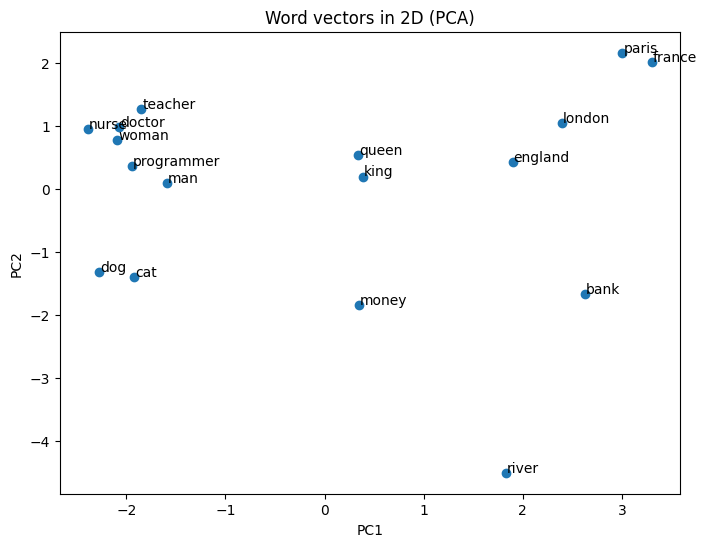

In [7]:
words_to_plot = [
    "king", "queen", "man", "woman",
    "paris", "france", "london", "england",
    "doctor", "nurse", "programmer", "teacher",
    "money", "bank", "river", "dog", "cat"
]
words_to_plot = [w for w in words_to_plot if has_word(w)]
X = np.stack([get_vector(w) for w in words_to_plot], axis=0)

pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X2[:, 0], X2[:, 1])
for i, w in enumerate(words_to_plot):
    plt.text(X2[i, 0] + 0.01, X2[i, 1] + 0.01, w)
plt.title("Word vectors in 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## 5) Scaled dot-product attention 

Attention(Q,K,V) = softmax(QK^T / sqrt(d_k)) V

I implement it directly, then visualize the attention matrix as a heatmap.


out: (1, 4, 8) attn: (1, 4, 4)


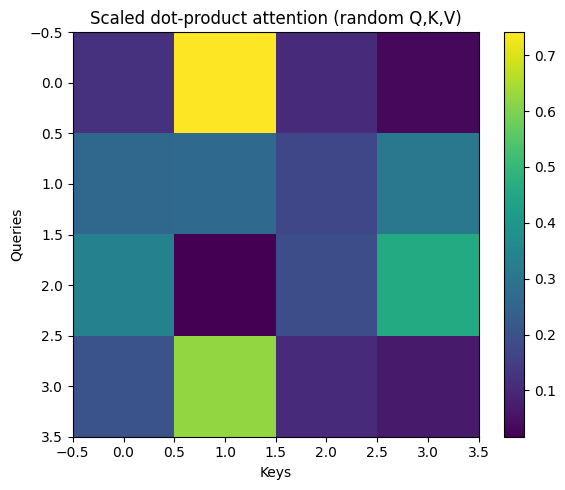

In [8]:
import torch
import torch.nn.functional as F

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attn = F.softmax(scores, dim=-1)
    out = torch.matmul(attn, V)
    return out, attn

def plot_attention(attn_matrix, tokens=None, title="Attention weights"):
    A = attn_matrix.detach().cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(A, aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    if tokens is not None:
        plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
        plt.yticks(range(len(tokens)), tokens)
    plt.tight_layout()
    plt.show()

torch.manual_seed(0)
Q = torch.randn(1, 4, 8)
K = torch.randn(1, 4, 8)
V = torch.randn(1, 4, 8)

out, attn = scaled_dot_product_attention(Q, K, V)
print("out:", tuple(out.shape), "attn:", tuple(attn.shape))
plot_attention(attn[0], title="Scaled dot-product attention (random Q,K,V)")


### How does `d_k` affect “peakiness”?

I summarize peakiness by the average max weight per row.


In [9]:
def avg_row_max(attn_matrix):
    A = attn_matrix.detach().cpu().numpy()
    return float(np.mean(A.max(axis=-1)))

for d_k in [4, 16, 64, 256]:
    Q = torch.randn(1, 6, d_k)
    K = torch.randn(1, 6, d_k)
    V = torch.randn(1, 6, d_k)
    _, attn = scaled_dot_product_attention(Q, K, V)
    print(f"d_k={d_k:>3d}  avg max weight per row={avg_row_max(attn[0]):.3f}")


d_k=  4  avg max weight per row=0.371
d_k= 16  avg max weight per row=0.454
d_k= 64  avg max weight per row=0.409
d_k=256  avg max weight per row=0.406


## 6) Multi-head self-attention

This is the same idea, repeated across multiple heads.


out: (1, 7, 32) attn: (1, 4, 7, 7)


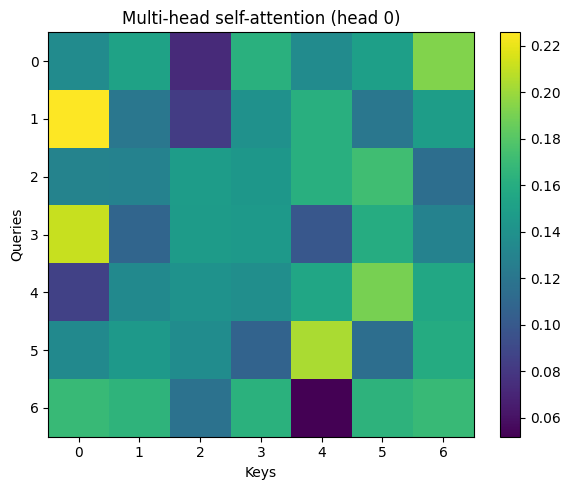

In [10]:
class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.Wq = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wk = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wv = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wo = torch.nn.Linear(d_model, d_model, bias=False)

    def split_heads(self, x):
        b, seq, d_model = x.shape
        return x.view(b, seq, self.num_heads, self.d_k).transpose(1, 2)  # (b, h, seq, d_k)

    def combine_heads(self, x):
        b, h, seq, d_k = x.shape
        return x.transpose(1, 2).contiguous().view(b, seq, h * d_k)

    def forward(self, x):
        Q = self.split_heads(self.Wq(x))
        K = self.split_heads(self.Wk(x))
        V = self.split_heads(self.Wv(x))

        b, h, seq, d_k = Q.shape
        Q2 = Q.reshape(b*h, seq, d_k)
        K2 = K.reshape(b*h, seq, d_k)
        V2 = V.reshape(b*h, seq, d_k)

        out2, attn2 = scaled_dot_product_attention(Q2, K2, V2)
        out = out2.reshape(b, h, seq, d_k)
        attn = attn2.reshape(b, h, seq, seq)

        out = self.Wo(self.combine_heads(out))
        return out, attn

torch.manual_seed(0)
mha = MultiHeadSelfAttention(d_model=32, num_heads=4)
x = torch.randn(1, 7, 32)
out, attn = mha(x)

print("out:", tuple(out.shape), "attn:", tuple(attn.shape))
plot_attention(attn[0, 0], title="Multi-head self-attention (head 0)")


## 7) Connect embeddings + self-attention on a sentence

Now I use word embeddings as my vectors and run self-attention on them.
Then I inspect which words “it” attends to.


In [11]:
def sentence_to_matrix(tokens):
    vecs, kept = [], []
    for t in tokens:
        v = get_vector(t)
        if v is None:
            continue
        vecs.append(v)
        kept.append(t)
    return np.stack(vecs, axis=0), kept

tokens = ["the", "dog", "chased", "the", "cat", "because", "it", "was", "fast"]
Xmat, kept = sentence_to_matrix(tokens)

# If toy fallback is active, many common words won't exist.
if len(kept) < 4:
    tokens = ["dog", "chased", "cat", "because", "it", "fast"]
    Xmat, kept = sentence_to_matrix(tokens)

print("Tokens used:", kept)
print("Matrix shape:", Xmat.shape)


Tokens used: ['the', 'dog', 'chased', 'the', 'cat', 'because', 'it', 'was', 'fast']
Matrix shape: (9, 50)


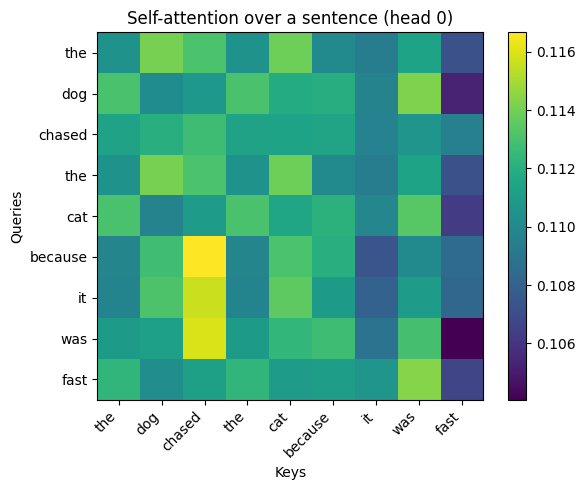

In [12]:
# Project embedding dim -> d_model so attention has a consistent size.
d_model = 32
num_heads = 4

embed_dim = Xmat.shape[1]
proj = torch.nn.Linear(embed_dim, d_model, bias=False)

x = torch.tensor(Xmat, dtype=torch.float32).unsqueeze(0)  # (1, seq, embed_dim)
x_proj = proj(x)  # (1, seq, d_model)

mha = MultiHeadSelfAttention(d_model=d_model, num_heads=num_heads)
out, attn = mha(x_proj)

plot_attention(attn[0, 0], tokens=kept, title="Self-attention over a sentence (head 0)")


In [13]:
def show_top_attention(attn_heads, tokens, query_token="it", head=0, topk=6):
    if query_token not in tokens:
        print(f"'{query_token}' not found.")
        return
    i = tokens.index(query_token)
    weights = attn_heads[0, head, i].detach().cpu().numpy()
    pairs = sorted(list(zip(tokens, weights)), key=lambda x: x[1], reverse=True)
    print(f"Top attention targets for '{query_token}' (head={head}):")
    for t, w in pairs[:topk]:
        print(f"  {t:>10s}  {w:.3f}")

for h in range(min(3, attn.shape[1])):
    show_top_attention(attn, kept, query_token="it", head=h, topk=6)


Top attention targets for 'it' (head=0):
      chased  0.116
         cat  0.114
         dog  0.113
         was  0.111
     because  0.111
         the  0.110
Top attention targets for 'it' (head=1):
        fast  0.119
      chased  0.117
         was  0.112
         dog  0.111
         cat  0.110
          it  0.108
Top attention targets for 'it' (head=2):
          it  0.116
         the  0.115
         the  0.115
     because  0.113
         was  0.113
         cat  0.108


## Notes / limitations 

- Word embeddings here are static: “bank” has one vector even though it has multiple meanings.
- The bias probe is tiny. A real bias evaluation needs bigger lists and stronger statistics.
- The attention demo is not trained on a task. It’s showing the mechanism, not “accuracy”.

This demonstrates my understanding of:
- how to inspect embeddings (neighbors + analogies)
- how bias can show up as association patterns
- how attention is implemented mathematically
- how to visualize attention weights (who looks at who)
